## Predicting Crypto Prices
### Using Machine Learning
Author: **Willie Cooley**


The following notebook was inspired by the medium article [_Predict Tomorrow's Bitcoin (BTC) Price with Recurrent Neural Networks_](https://towardsdatascience.com/using-recurrent-neural-networks-to-predict-bitcoin-btc-prices-c4ff70f9f3e4) by **Orhan Gazi Yalcin**

#### Steps 
  1. Obtaining Historical Crypto Prices
  2. Data Cleaning and Normalization
  3. Building a Recurrent Neural Net with Long Short Term Memory
  4. Training the RNN
  5. Predict tomorrow's price

In [1]:
import pandas as pd
import numpy as np
import requests
import random
import json
import time
import sys

In [2]:
# Coin class for retrieving, cleaning, and normalizing historical data
class Coin():
    valid_timeframes = ['24h', '7d', '30d', '1y', '5y']
    coin_id = { 'BTC': 1 }

    def __init__(self, coin_name='BTC', timeframe='30d', base='USD'):
        '''
            Constructor. sets the URL, Name, data, price matrix, and normalized prices
            of the given coin on creation
        '''
        self.update_coin_ids()
        if self.is_valid_coin(coin_name) and self.is_valid_timeframe(timeframe):
            try:
                self.timeframe = timeframe
                self.base = base
                self.coin_name = coin_name
                self.coin_url = self.generate_coin_url()
                self.data = self.get_historic_prices()
                self.price_matrix = self.get_price_matrix(30)
                self.normalized_prices = self.normalize_prices(self.price_matrix)
            except Exception as e:
                print("Exception Initializing Coin:: " + str(e))
        else:
            print('Invalid Argument(s) Detected.')

    def generate_coin_url(self):
        '''
            Generates a URL for retrieving historical coin data
        '''
        c_url = f'''https://api.coinranking.com/v1/public/coin/{self.coin_id[self.coin_name]}/history/{self.timeframe}?base={self.base}'''
        return c_url

    def get_stats(self):
        '''
            Returns an object with all active information on the coin object.
        '''
        statz = {'coin_name': self.coin_name, 'coin_id': self.coin_id[str(self.coin_name)],
                    'history_timeframe': self.timeframe,
                    'price_matrix': self.get_price_matrix, 'normalized_prices': self.normalized_prices}
        return statz
    
    def get_dataframe(self):
        '''
            Returns a pandas dataframe with available historical data and any requested indicators
        '''
        # TODO: add indicators as columns to dataframe
        return self.data

    def get_historic_prices(self):
        '''
            GETs historic price data for the given coin from the CoinRanking.com API
        '''
        try:
            r = requests.get(self.coin_url)
            coin = json.loads(r.text)['data']['history']
            df = pd.DataFrame(coin)
            df['price'] = pd.to_numeric(df['price'])
            df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms').dt.date
        except Exception as e:
            print("Exception Getting Historic Prices:: "+str(e))
            return -1
        return df.groupby('timestamp').mean()

    def get_price_matrix(self, seq_len):
        '''
            Converts the price series into a nested list where every item of the list contains
            the historic prices of seq_len number of days
            Function borrowed from: https://gist.github.com/ogyalcin/d893ddb1d49d389ffcfa94cb47e6f5bc#file-rnn_2-py
        '''
        try:
            price_matrix = []
            price_data = self.data['price']
            #print(str(range(len(price_data)-seq_len+1)))
            for index in range(len(price_data)-seq_len+1):
                print(f'adding {self.data[index:index+seq_len]}')
                price_matrix.append(price_data[index:index+seq_len])
            return price_matrix
        except Exception as e:
            print("Exception Getting Price Matrix:: " + str(e))

    def update_coin_ids(self):
        '''
            Function which updates the key/value pairs in self.coin_id to the latest
            information available from the Coinranking.com API
        '''
        c_url = 'https://api.coinranking.com/v1/public/coins'
        try:
            r = requests.get(c_url)
            coinz = json.loads(r.text)['data']['coins']
            for ele in coinz:
                self.coin_id[str(ele['symbol'])] = ele['id']
            return 0
        except Exception as e:
            print("Exception Updating Coin IDs: " + str(e))
            return -1

    def set_timeframe(self, new_tf):
        '''
            Modifies the timeframe parameter of the coin history
        '''
        self.timeframe = new_tf
        reload_data()
        return 0

    def set_base(self, new_base):
        '''
            Modifies the base currency parameter of the coin history
        '''
        self.base = new_base
        reload_data()
        return 0

    def reload_data(self):
        '''
            Updates coin information after parameter changes have been made
        '''
        try:
            self.coin_url = generate_coin_url()
            self.data = self.get_historic_prices()
            self.price_matrix = self.get_price_matrix(30)
            self.normalized_prices = self.normalize_prices(self.price_matrix)
        except Exception as e:
            print("Exception Reloading Data:: "+str(e))
            return -1
        return 0

    def normalize_prices(self, price_data):
        '''
            Normalizes each value to reflect the percentage changes from starting point
            Function borrowed from: https://gist.github.com/ogyalcin/d893ddb1d49d389ffcfa94cb47e6f5bc#file-rnn_2-py
        '''
        normalized_data = []
        try:
            for window in price_data:
                # TODO: check what's actually coming into window[0]
                print(float(window[0]))
                fw0_var = float(window[0]) if float(window[0]) != 0.0 else 1.0
                normalized_window = [((float(p) / fw0_var) - 1) for p in window]
                normalized_data.append(normalized_window)
            return normalized_data
        except Exception as e:
            print("Exception Normalizing Prices:: " +str(e))
            return -1


    # should I move this train_test_split elsewhere in the code?
    ## Options Include: app.py, coin.py, net.py
    def train_test_split_(self, train_size=0.9, shuffle=False, return_row=True):
        '''
            Makes a custom train test split where the last part is kept as the training set.
            Function borrowed from: https://gist.github.com/ogyalcin/d893ddb1d49d389ffcfa94cb47e6f5bc#file-rnn_2-py
        '''
        try:
            self.price_matrix = np.array(self.price_matrix)
            row = int(round(train_size * len(self.price_matrix)))
            train = self.price_matrix[:row, :]
            if shuffle==True:
                np.random.shuffle(train)
            X_train, y_train = train[:row,:-1], train[:row,-1]
            X_test, y_test = self.price_matrix[row:,:-1], self.price_matrix[row:,-1]
            X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
            X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
            if return_row:
                return row, X_train, y_train, X_test, y_test
            else:
                return X_train, y_train, X_test, y_test
        except Exception as e:
            print("Exception Splitting Train and Test Data: " + str(e))
            return -1

    def is_valid_coin(self, coin):
        '''
            Returns True if the provided string is one of the keys in self.coin_id
        '''
        # judging by coinranking's coin list, coins can be 2-5 characters in length
        # all upper-case, Alphabetical. Some coins include an asterisk (*)
        # TODO: regex that checks that input matches the above description
        return True if coin in self.coin_id.keys() else False

    def is_valid_timeframe(self, tf):
        '''
            Returns True if the provided string is present in the list self.valid_timeframes
        '''
        return True if tf in self.valid_timeframes else False

#### Obtaining Historical Bitcoin Prices
To accomplish this, we will make requests to CoinRanking.com's API.

In [25]:
my_eth = Coin('ETH', '1y', 'USD')
_, x_train, y_train, x_test, y_test = my_eth.train_test_split_()
eth_prices = my_eth.get_dataframe()

adding                  price
timestamp             
2019-03-06  139.803125
2019-03-07  140.925307
2019-03-08  139.739296
2019-03-09  139.807108
2019-03-10  137.925155
2019-03-11  135.641936
2019-03-12  134.529243
2019-03-13  134.036521
2019-03-14  133.642380
2019-03-15  136.455523
2019-03-16  142.289616
2019-03-17  140.483307
2019-03-18  139.826637
2019-03-19  139.683572
2019-03-20  139.365282
2019-03-21  138.960241
2019-03-22  138.082456
2019-03-23  138.434571
2019-03-24  137.911963
2019-03-25  136.585369
2019-03-26  134.986278
2019-03-27  139.166010
2019-03-28  139.763874
2019-03-29  141.104612
2019-03-30  144.776112
2019-03-31  142.441177
2019-04-01  142.796117
2019-04-02  153.284059
2019-04-03  168.328123
2019-04-04  160.703271
adding                  price
timestamp             
2019-03-07  140.925307
2019-03-08  139.739296
2019-03-09  139.807108
2019-03-10  137.925155
2019-03-11  135.641936
2019-03-12  134.529243
2019-03-13  134.036521
2019-03-14  133.642380
2019-03-15  136.4555

adding                  price
timestamp             
2019-04-24  164.844149
2019-04-25  163.628530
2019-04-26  154.970990
2019-04-27  156.155469
2019-04-28  156.991411
2019-04-29  154.129588
2019-04-30  155.520462
2019-05-01  159.638106
2019-05-02  158.886575
2019-05-03  163.678906
2019-05-04  161.920875
2019-05-05  161.234160
2019-05-06  165.441715
2019-05-07  173.433324
2019-05-08  168.643647
2019-05-09  168.921132
2019-05-10  171.801081
2019-05-11  185.046726
2019-05-12  189.120180
2019-05-13  193.003185
2019-05-14  205.449912
2019-05-15  229.363057
2019-05-16  257.955592
2019-05-17  236.336775
2019-05-18  237.984398
2019-05-19  251.906840
2019-05-20  248.017652
2019-05-21  251.874954
2019-05-22  252.671674
2019-05-23  240.761658
adding                  price
timestamp             
2019-04-25  163.628530
2019-04-26  154.970990
2019-04-27  156.155469
2019-04-28  156.991411
2019-04-29  154.129588
2019-04-30  155.520462
2019-05-01  159.638106
2019-05-02  158.886575
2019-05-03  163.6789

adding                  price
timestamp             
2019-05-22  252.671674
2019-05-23  240.761658
2019-05-24  247.859578
2019-05-25  249.441144
2019-05-26  251.143436
2019-05-27  264.889450
2019-05-28  267.726494
2019-05-29  267.793102
2019-05-30  272.301269
2019-05-31  257.527222
2019-06-01  266.551742
2019-06-02  264.633994
2019-06-03  263.046962
2019-06-04  245.117126
2019-06-05  243.810604
2019-06-06  243.738776
2019-06-07  248.868189
2019-06-08  248.052383
2019-06-09  237.746760
2019-06-10  239.727374
2019-06-11  242.456820
2019-06-12  248.593169
2019-06-13  257.475555
2019-06-14  256.745530
2019-06-15  264.049424
2019-06-16  267.403103
2019-06-17  269.506154
2019-06-18  266.125752
2019-06-19  265.902113
2019-06-20  271.227244
adding                  price
timestamp             
2019-05-23  240.761658
2019-05-24  247.859578
2019-05-25  249.441144
2019-05-26  251.143436
2019-05-27  264.889450
2019-05-28  267.726494
2019-05-29  267.793102
2019-05-30  272.301269
2019-05-31  257.5272

2019-07-17  206.872300
adding                  price
timestamp             
2019-06-19  265.902113
2019-06-20  271.227244
2019-06-21  283.743647
2019-06-22  300.392290
2019-06-23  306.435283
2019-06-24  304.674760
2019-06-25  309.158217
2019-06-26  331.716520
2019-06-27  306.611274
2019-06-28  299.702910
2019-06-29  302.291722
2019-06-30  303.438059
2019-07-01  289.351738
2019-07-02  284.521497
2019-07-03  294.691151
2019-07-04  294.470082
2019-07-05  288.602192
2019-07-06  290.947838
2019-07-07  292.672295
2019-07-08  305.840730
2019-07-09  308.067794
2019-07-10  297.920952
2019-07-11  275.313560
2019-07-12  274.609813
2019-07-13  270.541938
2019-07-14  250.943190
2019-07-15  229.412825
2019-07-16  218.998974
2019-07-17  206.872300
2019-07-18  218.758610
adding                  price
timestamp             
2019-06-20  271.227244
2019-06-21  283.743647
2019-06-22  300.392290
2019-06-23  306.435283
2019-06-24  304.674760
2019-06-25  309.158217
2019-06-26  331.716520
2019-06-27  306.6112

2019-09-06  172.525069
adding                  price
timestamp             
2019-08-09  210.592654
2019-08-10  206.793702
2019-08-11  210.442313
2019-08-12  210.231103
2019-08-13  205.711398
2019-08-14  202.340232
2019-08-15  184.990476
2019-08-16  189.967679
2019-08-17  185.557983
2019-08-18  190.740487
2019-08-19  199.352812
2019-08-20  198.468760
2019-08-21  188.371709
2019-08-22  188.869885
2019-08-23  193.312311
2019-08-24  190.247314
2019-08-25  188.190094
2019-08-26  188.718824
2019-08-27  186.372795
2019-08-28  182.169122
2019-08-29  170.355135
2019-08-30  169.726689
2019-08-31  169.852976
2019-09-01  176.321688
2019-09-02  174.827053
2019-09-03  179.226309
2019-09-04  177.078644
2019-09-05  172.179195
2019-09-06  172.525069
2019-09-07  171.532006
adding                  price
timestamp             
2019-08-10  206.793702
2019-08-11  210.442313
2019-08-12  210.231103
2019-08-13  205.711398
2019-08-14  202.340232
2019-08-15  184.990476
2019-08-16  189.967679
2019-08-17  185.5579

adding                  price
timestamp             
2019-10-05  176.205716
2019-10-06  174.031790
2019-10-07  177.374431
2019-10-08  181.121619
2019-10-09  186.410973
2019-10-10  191.930289
2019-10-11  186.008095
2019-10-12  183.078624
2019-10-13  183.000757
2019-10-14  183.696187
2019-10-15  182.739526
2019-10-16  177.692918
2019-10-17  177.641626
2019-10-18  175.861890
2019-10-19  175.260025
2019-10-20  174.894767
2019-10-21  175.375119
2019-10-22  174.660762
2019-10-23  165.197117
2019-10-24  162.654485
2019-10-25  171.463687
2019-10-26  182.027541
2019-10-27  180.863232
2019-10-28  183.224355
2019-10-29  187.022442
2019-10-30  184.835260
2019-10-31  182.369863
2019-11-01  181.686039
2019-11-02  183.298745
2019-11-03  182.478019
adding                  price
timestamp             
2019-10-06  174.031790
2019-10-07  177.374431
2019-10-08  181.121619
2019-10-09  186.410973
2019-10-10  191.930289
2019-10-11  186.008095
2019-10-12  183.078624
2019-10-13  183.000757
2019-10-14  183.6961

2019-11-24  149.351142
adding                  price
timestamp             
2019-10-27  180.863232
2019-10-28  183.224355
2019-10-29  187.022442
2019-10-30  184.835260
2019-10-31  182.369863
2019-11-01  181.686039
2019-11-02  183.298745
2019-11-03  182.478019
2019-11-04  184.823536
2019-11-05  187.967127
2019-11-06  191.236303
2019-11-07  188.590074
2019-11-08  185.841458
2019-11-09  185.662868
2019-11-10  188.340619
2019-11-11  187.466958
2019-11-12  187.123349
2019-11-13  187.215931
2019-11-14  185.873900
2019-11-15  182.461874
2019-11-16  181.940553
2019-11-17  183.888457
2019-11-18  182.651818
2019-11-19  177.268229
2019-11-20  176.900084
2019-11-21  169.055253
2019-11-22  155.173645
2019-11-23  151.638671
2019-11-24  149.351142
2019-11-25  145.195224
adding                  price
timestamp             
2019-10-28  183.224355
2019-10-29  187.022442
2019-10-30  184.835260
2019-10-31  182.369863
2019-11-01  181.686039
2019-11-02  183.298745
2019-11-03  182.478019
2019-11-04  184.8235

2020-01-01  130.840571
adding                  price
timestamp             
2019-12-04  149.171533
2019-12-05  149.316905
2019-12-06  150.353639
2019-12-07  150.483619
2019-12-08  150.923219
2019-12-09  149.631908
2019-12-10  146.922410
2019-12-11  145.353831
2019-12-12  144.046417
2019-12-13  145.295006
2019-12-14  144.105604
2019-12-15  142.881824
2019-12-16  139.341199
2019-12-17  130.272795
2019-12-18  126.435458
2019-12-19  129.109062
2019-12-20  128.818398
2019-12-21  128.649496
2019-12-22  130.041971
2019-12-23  131.926075
2019-12-24  128.703155
2019-12-25  125.778983
2019-12-26  126.337517
2019-12-27  125.830588
2019-12-28  127.491384
2019-12-29  130.732086
2019-12-30  132.696738
2019-12-31  130.663022
2020-01-01  130.840571
2020-01-02  129.029454
adding                  price
timestamp             
2019-12-05  149.316905
2019-12-06  150.353639
2019-12-07  150.483619
2019-12-08  150.923219
2019-12-09  149.631908
2019-12-10  146.922410
2019-12-11  145.353831
2019-12-12  144.0464

2020-01-31  179.299365
adding                  price
timestamp             
2020-01-03  131.595954
2020-01-04  133.958869
2020-01-05  136.198692
2020-01-06  140.920370
2020-01-07  143.610159
2020-01-08  142.942274
2020-01-09  138.635009
2020-01-10  139.024258
2020-01-11  143.299958
2020-01-12  143.696954
2020-01-13  143.209528
2020-01-14  155.419928
2020-01-15  163.789744
2020-01-16  161.762326
2020-01-17  168.755405
2020-01-18  172.180700
2020-01-19  169.520897
2020-01-20  165.596862
2020-01-21  167.576811
2020-01-22  168.229833
2020-01-23  162.902367
2020-01-24  160.246639
2020-01-25  159.584024
2020-01-26  162.798185
2020-01-27  168.898065
2020-01-28  171.712908
2020-01-29  175.516821
2020-01-30  175.925824
2020-01-31  179.299365
2020-02-01  180.178111
adding                  price
timestamp             
2020-01-04  133.958869
2020-01-05  136.198692
2020-01-06  140.920370
2020-01-07  143.610159
2020-01-08  142.942274
2020-01-09  138.635009
2020-01-10  139.024258
2020-01-11  143.2999

142.4411774316
142.7961167496
153.2840594389
168.3281228473
160.703271046
162.95492997350001
165.1648381734
168.9285854625
179.64445169849998
177.1540860949
179.2358012634
167.6389794503
163.9915526097
164.01786005190002
163.8534138525
164.9333739317
163.429620777
166.525988912
172.26752676290002
171.6141861359
172.7515960709
169.76347485809998
169.56756776129998
173.25647799970002
164.8441490376
163.62852996459998
154.9709903485
156.15546935700002
156.9914113059
154.1295882263
155.5204617471
159.6381056385
158.8865749566
163.6789057247
161.9208746252
161.2341603201
165.4417153825
173.4333237829
168.6436468549
168.9211317096
171.8010809039
185.04672640060002
189.12018045
193.003184648
205.4499124552
229.3630572164
257.955592469
236.3367752875
237.9843982422
251.90684036
248.0176517816
251.8749541189
252.6716742479
240.76165843549998
247.8595780333
249.44114386270002
251.14343619009998
264.88945001919996
267.7264935241
267.7931015948
272.3012690752
257.5272221359
266.5517424825
264.6339

In [4]:
def plot_data(df):
    #print(df)
    try:
        df.plot(figsize=(21,7), alpha=0.75)
        return 0
    except Exception as e:
        print(str(e))
        return -1

0

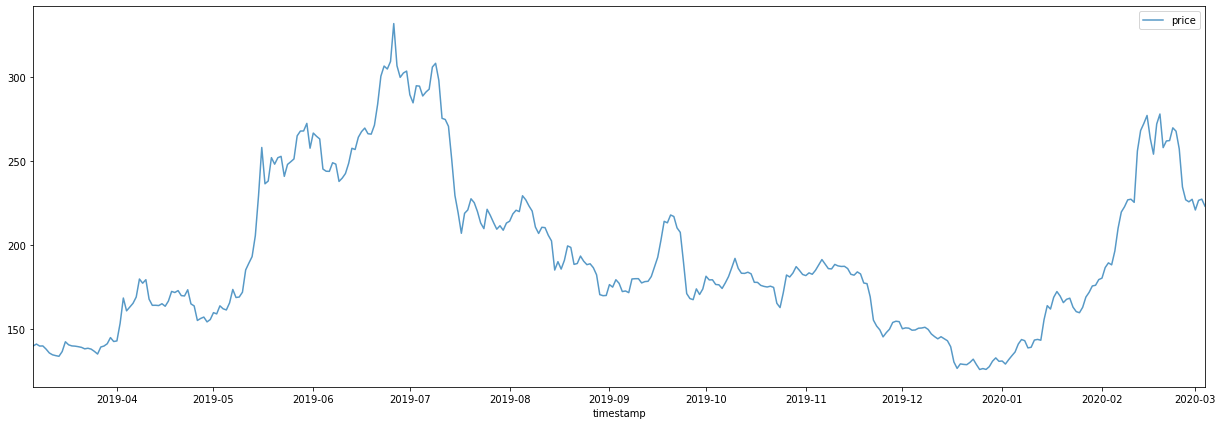

In [6]:
plot_data(eth_prices)

#### Building an RNN with LSTM
Pytorch Translation

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim

In [29]:
batch_size = 2
epochs = 15
input_shape = 1#(None, 1)
output_dim = 30

In [87]:
# The below is borrowed from
# https://romanorac.github.io/.../time-series-prediction-with-lstm.html

class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Net, self).__init__()
        self.input_size = input_shape
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.lstm = nn.LSTMCell(self.input_size, self.hidden_size)
        self.linear = nn.Linear(self.hidden_size, self.output_size)
        
    def forward(self, input, future=0, y=None):
        outputs = []
        
        # reset the state of the LSTM
        # the state is kept until the end of the sequence
        h_t = torch.zeros(input.size(0), self.hidden_size, dtype=torch.double)
        c_t = torch.zeros(input.size(0), self.hidden_size, dtype=torch.float)
        
        for i,input_t in enumerate(input.chunk(input.size(1), dim=1)):
            print("lstm:: {0}".format(str(type(self.lstm))))
            h_t,c_t = self.lstm(input_t, (h_t, c_t))
            output = self.linear(h_t)
            outputs += [output]
            
        for i in range(future):
            if y is not None and random.random() > 0.5:
                output = y[:, [i]]  # teacher forcing
            h_t,c_t = self.lstm(output, (h_t, c_t))
            output = self.linear(h_t)
            outputs += [output]
        outputs = torch.stack(outputs, 1).squeeze(2)
        return outputs

In [65]:
class Optimization:
    """ A helper class to train, test and diagnose the LSTM"""

    def __init__(self, model, loss_fn, optimizer, scheduler):
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.train_losses = []
        self.val_losses = []
        self.futures = []

    @staticmethod
    def generate_batch_data(x, y, batch_size):
        for batch, i in enumerate(range(0, len(x) - batch_size, batch_size)):
            x_batch = x[i : i + batch_size]
            y_batch = y[i : i + batch_size]
            print('batch type:: '+str(type(x_batch)))
            yield x_batch, y_batch, batch

    def train(self, x_train, y_train, x_val=None, y_val=None,
                batch_size=100, n_epochs=15, do_teacher_forcing=None):
        print('OPTIMIZATION.TRAIN()')
        x_train, y_train = self.data_to_tensor(x_train, y_train)
        seq_len = x_train.shape[1]
        for epoch in range(n_epochs):
            start_time = time.time()
            self.futures = []

            train_loss = 0
            for x_batch, y_batch, batch in self.generate_batch_data(x_train, y_train, batch_size):
                y_pred = self._predict(x_batch, y_batch, seq_len, do_teacher_forcing)
                self.optimizer.zero_grad()
                loss = self.loss_fn(y_pred, y_batch)
                loss.backward()
                self.optimizer.step()
                train_loss += loss.item()
            self.scheduler.step()
            train_loss /= batch
            self.train_losses.append(train_loss)

            self._validation(x_val, y_val, batch_size)

            elapsed = time.time() - start_time
            print(
                "Epoch %d Train loss: %.2f. Validation loss: %.2f. Avg future: %.2f. Elapsed time: %.2fs."
                % (epoch + 1, train_loss, self.val_losses[-1], np.average(self.futures), elapsed)
            )
    def data_to_tensor(self, x_train, y_train, x_val=None, y_val=None):
        x_train = torch.tensor(x_train, dtype=torch.double)
        y_train = torch.tensor(y_train, dtype=torch.double)
        if x_val is not None and y_val is not None:
            x_val = torch.tensor(x_val, dtype=torch.double)
            y_val = torch.tensor(y_val, dtype=torch.double)
            return x_train, y_train, x_val, y_val
        return x_train, y_train

    def _predict(self, x_batch, y_batch, seq_len, do_teacher_forcing):
        print('OPTIMIZATION.PREDICT()')
        if do_teacher_forcing:
            future = random.randint(1, int(seq_len) / 2)
            limit = x_batch.size(1) - future
            #print('Teacher Forcing!\nBEFORE Y_PRED\nx_batch:: '+x_batch)
            y_pred = self.model(x_batch[:, :limit], future=future, y=y_batch[:, limit:])
        else:
            future = 0
            #print('BEFORE Y_PRED\nx_batch:: '+ str(x_batch))
            print(type(self.model))
            y_pred = self.model(x_batch)
        print('AFTER Y_PRED...')
        self.futures.append(future)
        return y_pred

    def _validation(self, x_val, y_val, batch_size):
        if x_val is None or y_val is None:
            return
        with torch.no_grad():
            val_loss = 0
            for x_batch, y_batch, batch in self.generate_batch_data(x_val, y_val, batch_size):
                y_pred = self.model(x_batch)
                loss = self.loss_fn(y_pred, y_batch)
                val_loss += loss.item()
            val_loss /= batch
            self.val_losses.append(val_loss)

    def evaluate(self, x_test, y_test, batch_size, future=1):
        with torch.no_grad():
            test_loss = 0
            actual, predicted = [], []
            for x_batch, y_batch, batch in self.generate_batch_data(x_test, y_test, batch_size):
                y_pred = self.model(x_batch, future=future)
                y_pred = (
                    y_pred[:, -len(y_batch) :] if y_pred.shape[1] > y_batch.shape[1] else y_pred
                )
                loss = self.loss_fn(y_pred, y_batch)
                test_loss += loss.item()
                actual += torch.squeeze(y_batch[:, -1]).data.cpu().numpy().tolist()
                predicted += torch.squeeze(y_pred[:, -1]).data.cpu().numpy().tolist()
            test_loss /= batch
            return actual, predicted, test_loss

    def plot_losses(self):
        plt.plot(self.train_losses, label="Training loss")
        plt.plot(self.val_losses, label="Validation loss")
        plt.legend()
        plt.title("Losses")

In [11]:
def generate_sequence(scaler, model, x_sample, future=1000):
    """ Generate future values for x_sample with the model """
    y_pred_tensor = model(x_sample, future=future)
    y_pred = y_pred_tensor.cpu().tolist()
    y_pred = scaler.inverse_transform(y_pred)
    return y_pred

In [12]:
def to_dataframe(actual, predicted):
    return pd.DataFrame({"actual": actual, "predicted": predicted})


def inverse_transform(scalar, df, columns):
    for col in columns:
        df[col] = scaler.inverse_transform(df[col])
    return df

#### Training the RNN

In [88]:
model_1 = Net(input_size=input_shape, hidden_size=21, output_size=output_dim)
loss_fn_1 = nn.MSELoss()
optimizer_1 = optim.Adam(model_1.parameters(), lr=1e-3)
scheduler_1 = optim.lr_scheduler.StepLR(optimizer_1, step_size=5, gamma=0.1)
optimization_1 = Optimization(model_1, loss_fn_1, optimizer_1, scheduler_1)

In [89]:
#x_val, y_val optional arguments between train and test, graphed
optimization_1.train(x_train, y_train, n_epochs=epochs, batch_size=batch_size, do_teacher_forcing=False) 

OPTIMIZATION.TRAIN()
batch type:: <class 'torch.Tensor'>
OPTIMIZATION.PREDICT()
<class '__main__.Net'>
lstm:: <class 'torch.nn.modules.rnn.LSTMCell'>


RuntimeError: Expected object of scalar type Float but got scalar type Double for argument #4 'mat1'

In [ ]:
optimization_1.plot_losses()

#### Model Evaluation

In [ ]:
actual_1, predicted_1, test_loss_1 = optimization_1.evaluate(x_test, y_test, future=5, batch_size=100)
df_result_1 = to_dataframe(actual_1, predicted_1) 
df_result_1 = inverse_transform(scaler, df_result_1, ['actual', 'predicted'])
df_result_1.plot(figsize=(14, 7))
print("Test loss %.4f" % test_loss_1)

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))
df_result_1.iloc[2350:2450].plot(ax=axes[0], figsize=(14, 7))
df_result_1.iloc[16000:17500].plot(ax=axes[1], figsize=(14, 7))

In [ ]:
x_sample = x_test[0].reshape(1, -1)
y_sample = df_test.vwap[:1100]
 
y_pred1 = generate_sequence(scaler, optimization_1.model, x_sample)

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(range(100), y_pred1[0][:100], color="blue", lw=2, label="Predicted VWAP")
plt.plot(range(100, 1100), y_pred1[0][100:], "--", color="blue", lw=2, label="Generated VWAP")
plt.plot(range(0, 1100), y_sample, color="red", label="Actual VWAP")
plt.legend()

In [ ]:



















# EOF